*Теоретический материал:* https://youtu.be/mPqOuRChXTs?t=205

## Import библиотек

In [ ]:
pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 41kB/s 
     |████████████████████████████████| 3.8MB 57.5MB/s 
     |████████████████████████████████| 512kB 69.4MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=a5ea4b40ea9495942b4fec137fe9f1a36ec8853a098bc46cc4acb66e4c327030
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [ ]:
pip install keras==2.3

     |████████████████████████████████| 378kB 13.0MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gym         # загружаем "тренажер" Gym из платформы OpenAi, предоставляющий среду для работы над обучением с подкреплением 
import numpy as np # импортируем библиотеку для работы с массивами данных
import keras       # импортируем нейросетевую библиотеку 
from keras.models import Model, load_model # из кераса подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from keras.layers import Dense, Flatten, Input, Lambda, Conv2D, MaxPooling2D, Reshape, Multiply # из кераса загружаем необходимые слои для нейросети
from keras.optimizers import RMSprop, Adam # из кераса загружаем выбранный оптимизатор
import time                                # модуль для операций со временными характеристиками
import matplotlib.pyplot as plt            # импортируем библиотеку для визуализации данных
 
# "магическая" команда python для запуска библиотеки в ноутбуке
%matplotlib inline

Using TensorFlow backend.


## Взгляд на игру

*Разбор данного раздела:* https://youtu.be/mPqOuRChXTs?t=4740

In [ ]:
env = gym.make('Pong-v0') # создаем среду игры Понг средствами OpenAI Gym('env' = environment)
observation = env.reset() # задаем начальное состояние среды, которое наблюдает агент
observation.shape         # взглянем на форму состояния среды
                          # увидим, что это изображение размером 210*160 с тремя RGB каналами

(210, 160, 3)

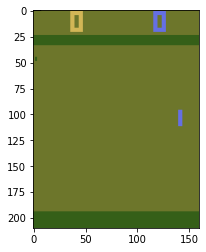

In [ ]:
plt.imshow(observation) # вызовем визуализацию состояния среды с помощью метода imshow от matplotlib.pyplot
plt.show() 

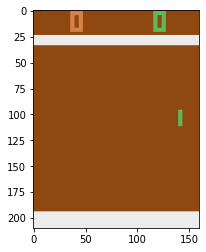

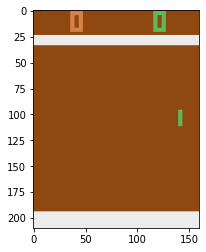

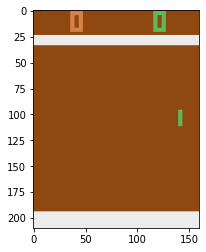

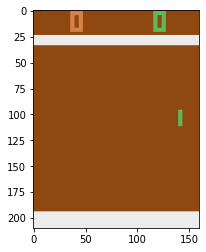

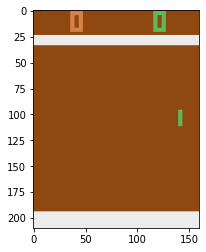

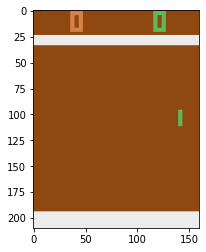

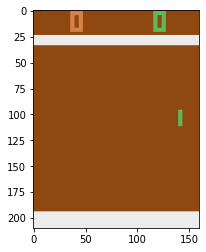

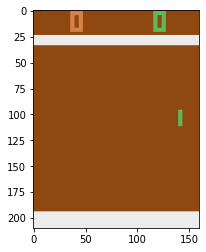

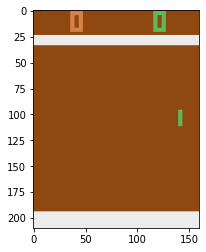

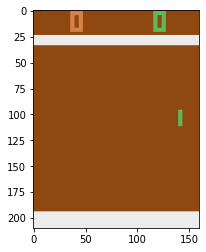

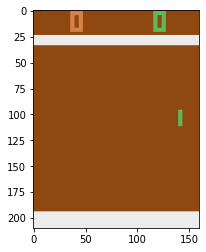

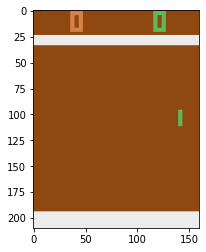

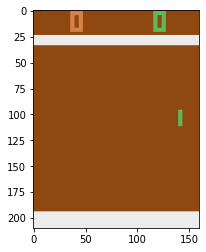

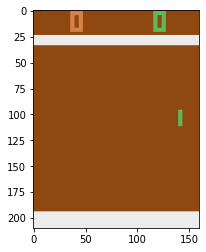

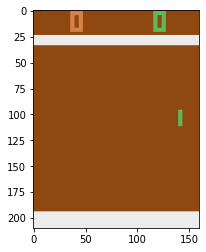

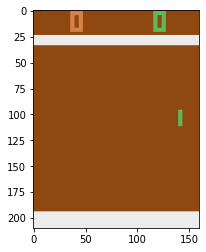

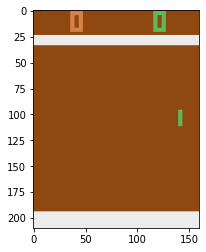

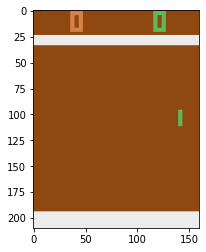

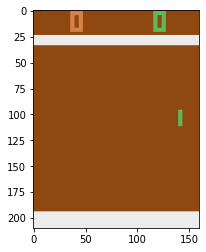

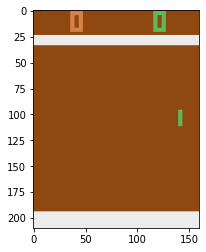

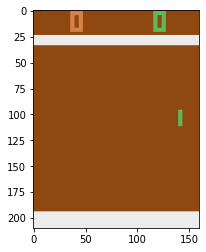

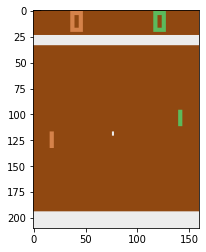

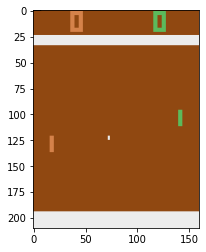

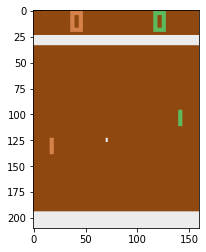

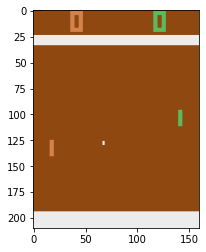

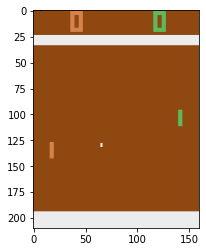

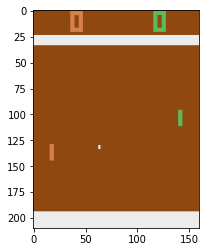

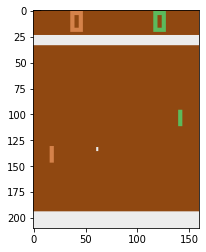

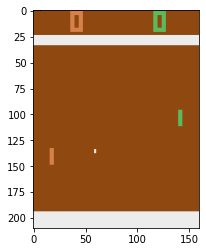

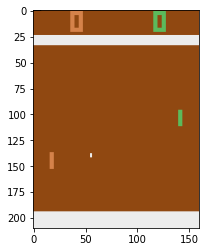

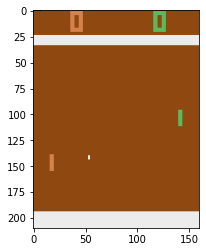

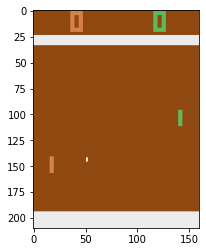

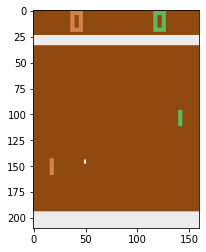

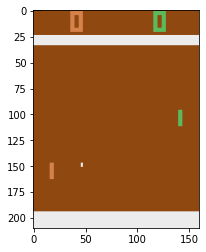

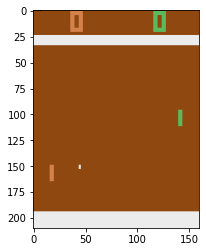

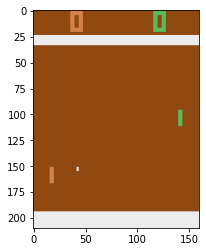

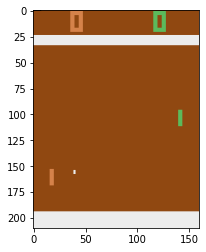

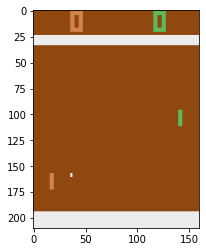

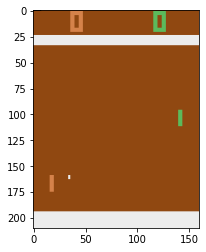

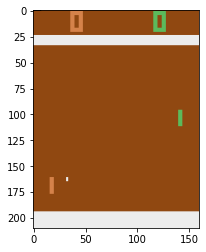

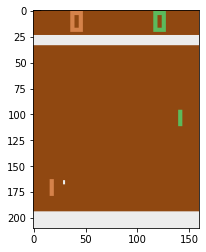

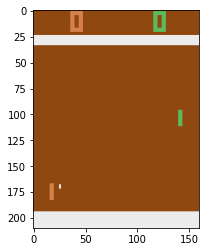

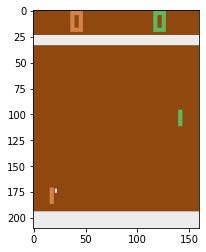

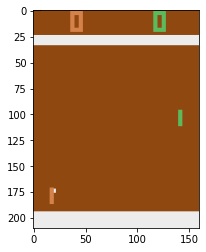

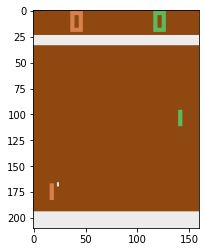

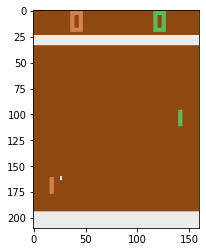

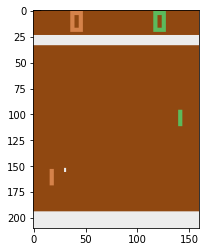

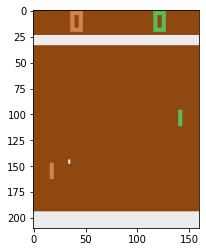

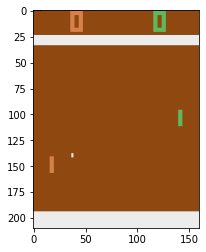

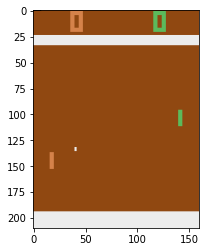

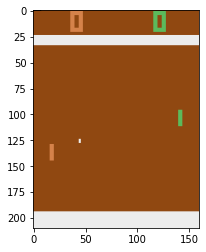

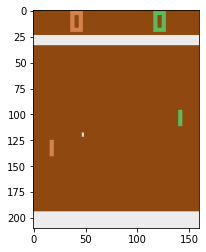

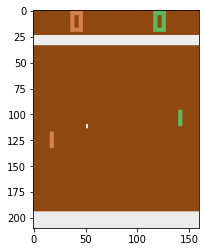

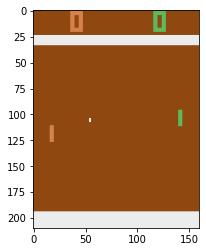

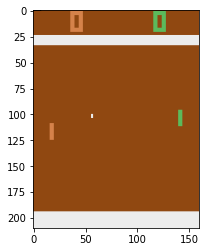

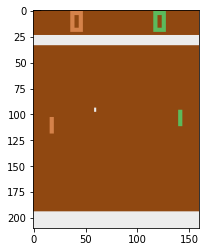

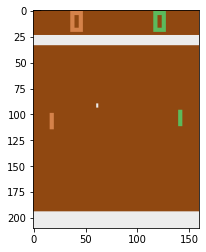

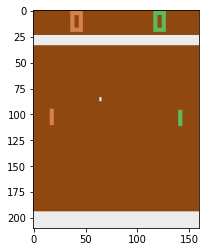

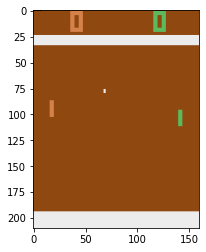

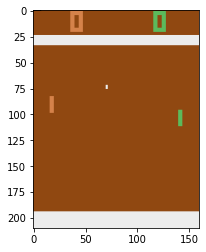

In [ ]:
# В понге:
# 0 цифровое обозначение если ракетка 'остаётся на месте'
# 2 цифровое обозначение для действия ракеткой 'сдвинуться вверх'
# 3 цифровое обозначение для действия ракеткой 'сдвинуться вниз'
 
# Проиграем вперёд игру на 30 кадров чтобы увидеть полную сцену игры
for i in range(60):
    # env.render()
    observation, reward, done, info = env.step(0) # 0 обозначает,что ничего не делаем, остаемся на месте
    plt.imshow(observation)                      # взглянем на текущее состояние среды: наш агент владеет зелёной ракеткой, появился соперник и мяч
    plt.show()
# step - такт, шаг в игре: принимает (action, действие агента), возвращает кортеж (observation, reward, done, info)
# observation (object) - текущее состояние среды, которое наблюдает агент(пиксели)
# reward (float) - награда за совершённое действие
# done (True or False) - обозначает завершился ли игровой эпизод (в понге до победы 21 очко)
# info (dict) - вспомогательная диагностическая информация, типа кол-во оставшихся жизней(неактуально для понга)

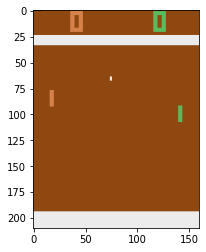

In [ ]:
# Policy(политику, стратегию агента) будет позже задавать нейросеть.
# мы подадим ей разницу между новым и предыдущим кадром, чтобы отслеживалось смещение мяча/ракеток и данные были понятными
newObservation, reward, done, info = env.step(2) # задаем очередным шагом следующий кадр, при этом смещая ракетку вверх
plt.imshow(newObservation)                       # взглянем на следующий кадр(нам смещение едва видно, либо не видно, т.к визуально длина шага мала)

## Предобработка данных

*Разбор данного раздела:* https://youtu.be/mPqOuRChXTs?t=4982

In [ ]:
# Зададим функцию предобработки данных для подачи в нейросеть
# избавимся вот всего лишнего(фон, размер и т.п), оставив на экране лишь мяч и ракетки
def preprocessFrames(newFrame,lastFrame): # подаем в функцию новый и предыдущий кадр
  nFrame = newFrame.astype(np.int32)      # переводим в целочисленный тип новый кадр
  nFrame[nFrame==144] = 0                 # удаляем цвета заднего фона в новом кадре(144 и 72 - значения каналов, дающих оранжевый цвет, зануляем)
  nFrame[nFrame==72] = 0                  # удаляем цвета заднего фона в новом кадре(144 и 72 - значения каналов, дающих оранжевый цвет, зануляем)  
  lFrame = lastFrame.astype(np.int32)     # переводим в целочисленный тип предыдущий кадр
  lFrame[lFrame==144] = 0                 # удаляем цвета заднего фона в новом кадре(144 и 72 - значения каналов, дающих оранжевый цвет, зануляем)
  lFrame[lFrame==72] = 0                  # удаляем цвета заднего фона в новом кадре(144 и 72 - значения каналов, дающих оранжевый цвет, зануляем)  
  deltaFrame = nFrame - lFrame            # задаём разницу между новым и предыдущим кадром   
  # Отрезаем верхнюю и нижнюю(неинформативные) части экрана, по 35 сверху и снизу
  deltaFrame = deltaFrame[35:195]         # срезали края по высоте, осталась картинка 160*160
  # Делаем сжатие кадра в 2 раза по обеим сторонам изображения и оставляем монотонный канал 
  deltaFrame=deltaFrame[::2,::2, 0]
  # Масштабирование чисел от 0 до 1
  maxValue = deltaFrame.max() if deltaFrame.max()> abs(deltaFrame.min()) else abs(deltaFrame.min())
  if maxValue != 0:
      deltaFrame=deltaFrame/maxValue
  return deltaFrame                       # функция вернет разницу между кадрами в оптимальном виде

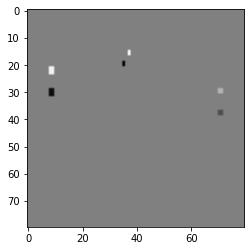

In [ ]:
plt.imshow(preprocessFrames(newObservation, observation), plt.cm.gray) # выведем результат предобработки наших кадров
# смещение здесь - это шаг от черного пикселя к светлому

In [ ]:
preprocessFrames(newObservation, observation) # выведем массив для этого состояния среды(кадра)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
preprocessFrames(newObservation, observation).shape # выведем форму массива

(80, 80)

In [ ]:
# Cостоянием среды будет картинка 80*80, полученная вычитанием двух последовательных кадров, где по итогу все будет...
# ...заполнено нулями, а в местах смещения мяча либо ракетки - ненулевые значения.
# Далее keras'ом создадим policy, которая на основе состояния(картинки) выбирает действия.
# Output сети - вероятность того что нужно двигаться вверх

## Моделируем нейросеть

*Разбор данного раздела:* https://youtu.be/mPqOuRChXTs?t=5306

In [ ]:
# Простая модель с двумя слоями, на 200 нейронов в скрытом слое и сигмоидой на выходе
inputs = Input(shape=(80,80))      # на входном слое сетки изображение 80*80
flattenedLayer = Flatten()(inputs) # перевели в вектор
fullConnected = Dense(200, activation='relu', use_bias=False)(flattenedLayer) # задали 200 нейронов и активацию релу
sigmoidOutput = Dense(1, activation='sigmoid', use_bias=False)(fullConnected)       # сигмоида на выходе
policyNetworkModel = Model(inputs=inputs, outputs=sigmoidOutput)                    # собрали модель стратегии(Model - абстрактный класс базовой модели)
policyNetworkModel.summary()       # посмотрим на модель

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               1280000   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 200       
Total params: 1,280,200
Trainable params: 1,280,200
Non-trainable params: 0
_________________________________________________________________


##Задаем функцию потерь в соответствии с вознаграждением

*Разбор данного раздела:* https://youtu.be/mPqOuRChXTs?t=5376

In [ ]:
# episode - одна тренировочная игра от начала партии до перезагрузки (розыгрыш эпизода до 21 очка; после победы или поражения вызываем reset)
episodeReward = Input(shape=(1,), name='episodeReward') # задаем награду за эпизод

In [ ]:
###########################
# Функция потерь в керасе имеет вид def loss(yTrue,yPred):...А так как нам нужно включить reward в loss, создаем...
# ...функцию rewardedLoss поверх неё, чтобы на входе добавить episodeReward
###########################
def rewardedLoss(episodeReward): # задаем новую функцию потерь, принимающую episodeReward, награда
  def loss(yTrue,yPred):
    # подаём в кач-ве yTrue фактически сделанное действие(action) 
    # если фактически сделанное действие было движением вверх - подаем 1 на yTrue, если нет то подаем 0
    # yPred - выход сетки(вероятность выбора движения вверх)
    # мы не подаём yPred в нейронку, его вычисляет керас
    
    # сначала log(0) and log(1) неопределены - загоняем yPred между значениями:
    tmpPred = Lambda(lambda x: keras.backend.clip(x,0.05,0.95))(yPred)
    # вычисляем логарифм вероятности. yPred - вероятность выбора движения вверх 
    # помним что yTrue = 1 когда фактически выбрано движение вверх, и 0 - когда вниз
    # формула похожа на кросс-энтропию в керасе, но здесь мы прописываем её вручную, чтобы умножить на значение награды
    tmpLoss = Lambda(lambda x:-yTrue*keras.backend.log(x)-(1-yTrue)*(keras.backend.log(1-x)))(tmpPred)
    # обновленная функция потерь - "функция политики"
    policyLoss = Multiply()([tmpLoss, episodeReward]) #добавляем в loss умножение на награду за эпизод
    return policyLoss # ввели обновленную функцию политики
  return loss         # возвращаем обновленную функцию политики

In [ ]:
###########################
# Создаем керас-оптимизатор и нейронку для обучения
###########################
episodeReward = Input(shape=(1,), name='episodeReward')                             # задаем награду за эпизод
policyNetworkTrain = Model(inputs=[inputs, episodeReward],outputs=sigmoidOutput)    # задаем сеть с добавлением на вход награды
 
myOptimizer = RMSprop(lr=0.0001)                                                    # выбрали оптимизатор с заданной скоростью обучения
policyNetworkTrain.compile(optimizer=myOptimizer, loss=rewardedLoss(episodeReward)) # задаем сеть с новой функцией потерь policy

## Генерация игрового эпизода с участием нейросети

*Разбор данного раздела:* https://youtu.be/mPqOuRChXTs?t=6036

In [ ]:
###########################
# Создадим функцию, которая будет генерировать игровой эпизод с участием нейросети
###########################
#игра начнется с того, что в новом эпизоде наш агент сделает движение("actualAction") вверх с вероятностью(upProbability), которую предсказала наша...
#...сетка policyNetwork, принявшая на вход состояние среды reshapedInput с подбитой под сеть формой. 
#reshapedInput же получили из состояния processedNetworkInput, которое представляет собой разницу в кадрах между новым и предыдущим...
#...кадром, полученную функцией preprocessFrames.
 
 
def generateEpisode(policyNetwork): # подаем на вход функции модель нейросети
  statesList = []                   # список состояний в течение эпизода, размер = (x,80,80)
  upDownActionList=[]               # список движений в течение эпизода: вверх - 1, вниз - 0
  rewardsList=[]                    # список наград за каждое действие
  networkOutputList=[]              # на выходе нейросети - вероятность что нужно идти вверх; собираем список из вероятности на каждом шаге
  env=gym.make("Pong-v0")           # cоздали среду
  observation = env.reset()         # перезагрузили состояние среды
  newObservation = observation      # получили новое состояние, которое наблюдает агент
  done = False                      # игровой эпизод активен(не завершён)
 
  while done == False: # пока игровой эпизод не завершён
    # На вход сети будет подаваться очередное состояние - разница между кадрами. 
    processedNetworkInput = preprocessFrames(newFrame=newObservation, lastFrame=observation) # зададим это состояние
    statesList.append(processedNetworkInput) # добавим в список состояний (впоследствие станет 'x'ом для входа в нейронку)
    reshapedInput = np.expand_dims(processedNetworkInput, axis=0) # размер 'x' - (80,80), делаем размерность (x,(1,80,80))
 
    upProbability = policyNetwork.predict(reshapedInput, batch_size=1)[0][0] # задаем вероятность шага вверх
    networkOutputList.append(upProbability) # добавляем к списку из вероятности идти вверх на каждом шаге
    actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability, 1-upProbability])
    # сделаем фактический шаг либо вверх(2) c вероятностью upProbability, либо вниз(3) с обратной вероятностью
 
    if actualAction == 2:        # если пошли вверх
      upDownActionList.append(1) # добавляем единицу в список движений в течение эпизода
    else:                        # если не пошли вверх
      upDownActionList.append(0) # то добавляем ноль
 
    observation = newObservation # текущий newObservation записываем как старый перед тем, как сделать следующий шаг
    newObservation, reward, done, info = env.step(actualAction) # сделали новый шаг, получили новую награду, новое состояние
 
    rewardsList.append(reward)   # добавили текущую награду в список
 
    if done: # если игровой эпизод закончен
      break  # завершаем цикл
 
  env.close() # закрываем текущую среду
  return statesList, upDownActionList, rewardsList, networkOutputList
  # функция возвращает: список состояний в течение эпизода,список движений в течение эпизода, список наград за каждое действие,
  # и список вероятностей того, что нужно идти вверх

In [ ]:
###########################
# Сгенерируем эпизод игры с необученной сетью
###########################
statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(policyNetworkModel)
print("----------------------")
print("Количество состояний в эпизоде = "+str(len(statesList))) # количество состояний (кадров) в эпизоде
print("Форма состояния "+str(statesList[0].shape))              # форма каждого состояния
print("Количество наград за эпизод = "+str(len(rewardsList)))   # количество наград за эпизод(включая нулевые награды)


----------------------
Количество состояний в эпизоде = 1184
Форма состояния (80, 80)
Количество наград за эпизод = 1184


In [ ]:
# Взглянем на фрагмент списка из вероятности идти вверх на каждом шаге.
print(networkOutputList[50:70])
# увидим что на каждом шаге вероятность крутится около 50% - сеть пока не понимает куда лучше шагать

[0.49731487, 0.54376453, 0.51209044, 0.53726494, 0.51787883, 0.5215354, 0.5001495, 0.5246843, 0.51280254, 0.5267103, 0.51441896, 0.49851325, 0.49798086, 0.4862646, 0.5337911, 0.50585634, 0.5243277, 0.5119107, 0.52049404, 0.5097189]


In [ ]:
# Взглянем на фактические действия: 1 - вверх, 0 - вниз
upDownActionList[50:70]
# Соответственно шаги также были случайными

[1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]

In [ ]:
# Выведем список наград(почти везде нули, кроме тех моментов когда выигрываем или проигрываем очко)
print(rewardsList[50:70])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# Взглянем на то, сколько мы раз выиграли в течение эпизода:
print("Количество выигранных очков = "+str(len(list(filter(lambda r: r>0,rewardsList))))) #берем как длину списка, отфильтрованного по наградам,большим 0
print("Количество проигранных очков = "+str(len(list(filter(lambda r: r<0,rewardsList))))) #берем как длину списка, отфильтрованного по наградам,меньшим 0
print("Количество нулевых наград = "+str(len(list(filter(lambda r: r==0,rewardsList))))) #с фильтром по 0

Количество выигранных очков = 0
Количество проигранных очков = 21
Количество нулевых наград = 1163


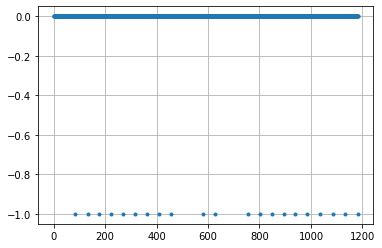

In [ ]:
# Выведем на графике полученные награды. Ненулевые награды за каждое очко будут отмечены точками.
plt.plot(rewardsList, '.') # точки будут наградами на графике
ax=plt.gca()               # получим текущие оси
ax.grid(True)              # с фоновой сеткой

## Эффективно определяем вознаграждение

*Разбор данного раздела:* https://youtu.be/mPqOuRChXTs?t=6839

In [ ]:
# Награды пока присуждаются только тем движениям, в момент после которых было пропущено или забито очко. Но так мы научимся нескоро,
# нам нужно указать на важность действия чуть ранее, когда мы отбивали мяч ракеткой. Чтобы сетка поняла что отбивать мяч - это хорошо,
# распределим награду на все шаги, предшествующие забитому/пропущеному мячу, причем чем давнее был шаг, тем меньший коэффициент награды он получит.
 
###########################
# Сформулируем функцию, которая распределит ненулевую награду для всех шагов в удачном/неудачном розыгрыше
###########################
def processRewards(rewardList): # подадим в функцию список наград
  rewardDecay = 0.99            # установим высший коэффициент награды для ближнего действия к победному/проигрышному действию
  tmpReward = 0                 # создадим временную переменную для награды
  rewardDecayed = np.zeros_like(rewardList,dtype=np.float32) # создадим массив из нулей для нового формата наград
  for i in range(len(rewardList)-1,-1,-1): # будем идти в обратную сторону от награды с шагом "-1"
    if rewardList[i] == 0:                 # если награда нулевая 
      tmpReward = tmpReward*rewardDecay    # зададим ей коэффициент
      rewardDecayed[i] = tmpReward         # и добавим в массив
    else:                                  # иначе
      tmpReward = rewardList[i]            # оставим награду неизменной
      rewardDecayed[i] = tmpReward         # и введём в том же виде в массив
  # запустим нормализацию значений наград, что позволит сетке лучше понимать, где были хорошие и плохие шаги
  rewardDecayed -= np.mean(rewardDecayed)  # вычтем среднее
  rewardDecayed /= np.std(rewardDecayed)   # разделим на стандартное отклонение
  return rewardDecayed
  # функция возвращает обновленный формат наград

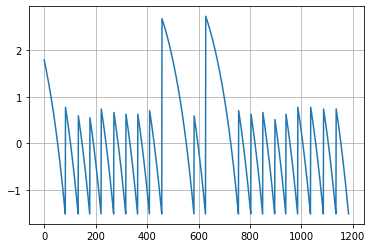

In [ ]:
# Посмотрим на распределение наград по новой функции
plt.plot(processRewards(rewardsList),'-') # добавляем в график награды с учетом новой функции
ax = plt.gca() # получим текущие оси
ax.grid(True)  # с фоновой сеткой
# новое распределение наград даст лучшее отражение эффективности действий

## Пример игрового эпизода с последующей тренировкой сети

*Разбор данного раздела:* https://youtu.be/mPqOuRChXTs?t=7332

In [ ]:
# Сгенерируем новый игровой эпизод:
statesList,upDownActionList,rewardsList,networkOutputList = generateEpisode(policyNetworkModel)
# сыграли до 21 очка, проиграли, получили списки всех состояний среды(кадров), шагов агента, вознаграждений и предсказаний
 
print("Количество состояний среды = "+str(len(statesList))) # выведем количество состояний среды(кадров) в игровом эпизоде
print("Форма состояний среды = "+str(statesList[0].shape))  # выведем форму для каждого состояния
print("Список наград  = "+str(len(rewardsList)))            # выведем список наград в игровом эпизоде(включая нулевые)

Количество состояний среды = 1092
Форма состояний среды = (80, 80)
Список наград  = 1092


In [ ]:
# Подготовим данные для тренировки    
x = np.array(statesList)          # зададим 'x' как массив состояний 
episodeReward = np.expand_dims(processRewards(rewardsList), 1) # подобьем размер для входа в сетку
yTmp = np.array(upDownActionList) # зададим 'y' как список движений вверх(1)/вниз(0)
yTrue = np.expand_dims(yTmp, 1)   # скорректируем форму под сетку
 
 
print("Форма наград за эпизод =", episodeReward.shape) # выведем форму наград за эпизод
print("Форма состояний среды =", x.shape)              # выведем форму состояний среды ('x' для нейросети)
print("Форма фактических движений =", yTrue.shape)     # выведем форму фактических движений ('y' для нейросети)

Форма наград за эпизод = (1092, 1)
Форма состояний среды = (1092, 80, 80)
Форма фактических движений = (1092, 1)


In [ ]:
episodeReward[:20]

array([[2.2933447],
       [2.2650495],
       [2.2364683],
       [2.2075984],
       [2.178437 ],
       [2.1489809],
       [2.1192274],
       [2.089173 ],
       [2.0588152],
       [2.028151 ],
       [1.9971769],
       [1.96589  ],
       [1.934287 ],
       [1.9023647],
       [1.87012  ],
       [1.8375496],
       [1.8046503],
       [1.7714185],
       [1.737851 ],
       [1.7039448]], dtype=float32)

In [ ]:
# "Скормим" модели новые 'x' и 'y'
policyNetworkTrain.fit(x=[x, episodeReward], y=yTrue)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/1
1092/1092 [==============================] - 0s 156us/step - loss: -0.0013


In [ ]:
###########################
# Теперь создадим серию игровых эпизодов
# Затем предобработаем данные и скормим нейросети
###########################
def generateEpisodeBatchesTraining(model, nBatches=10): # подаем на вход заданное количество игровых серий
  env = gym.make('Pong-v0')                             # создаем игровую среду Pong
  batchStateList = []                                   # зададим серию списков состояний
  batchUpDownActionList = []                            # зададим серию списков движений
  batchRewardsList = []                                 # зададим серию списков наград
  batchNetworkOutputList = []                           # зададим серию списков из вероятности идти вверх
  for i in range(nBatches):                             # для каждой серии 
    statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(model) # сгенерируем игровой эпизод
    batchStateList.extend(statesList)                   # добавим список состояний в серию списков состояний
    batchNetworkOutputList.extend(networkOutputList)    # добавим список вероятностей в серию списков из вероятности идти вверх
    batchUpDownActionList.extend(upDownActionList)      # добавим список движений в серию списков движений
    batchRewardsList.extend(rewardsList)                # добавим список наград в серию списков наград
 
  episodeReward = np.expand_dims(processRewards(batchRewardsList), 1) # зададим награды и изменим форму массива с добавлением оси
  x = np.array(batchStateList)                          # сформируем массив из серии списков состояний в качестве 'x' для нейросети
  yTmp = np.array(batchUpDownActionList)                # зададим 'y' как серию из списков движений вверх(1)/вниз(0)
  yTrue = np.expand_dims(yTmp, 1)                       # подгоним форму 'y' массива с добавлением оси
  
  history = policyNetworkTrain.fit(x=[x,episodeReward], y=yTrue, epochs=5, verbose=0) # скормим нейросети серию 'x'ов и 'y'ов
  
  batchLoss = history.history['loss'][-1]
  return batchStateList, batchUpDownActionList, batchRewardsList, batchNetworkOutputList, batchLoss
  # функция вернёт серию списков состояний, серию списков движений, серию списков наград, серию списков из вероятности идти вверх

## Обучаем сеть на серии игровых эпизодов

*Разбор данного раздела:* https://youtu.be/mPqOuRChXTs?t=7611

In [ ]:
trainingTimes = 120                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 46сек
Ошибка на тренировке = -0.03459
Выиграли очков = 6 Проиграли очков = 210

File ID: 1G6qMM6y_ikTPKYpTvA7Urbt7cyn612T-
Тренировка = 2
Время тренировки = 40сек
Ошибка на тренировке = -0.03795
Выиграли очков = 1 Проиграли очков = 210

Тренировка = 3
Время тренировки = 51сек
Ошибка на тренировке = -0.0519
Выиграли очков = 5 Проиграли очков = 210

Тренировка = 4
Время тренировки = 54сек
Ошибка на тренировке = -0.05794
Выиграли очков = 12 Проиграли очков = 210

Тренировка = 5
Время тренировки = 58сек
Ошибка на тренировке = -0.05901
Выиграли очков = 12 Проиграли очков = 210

Тренировка = 6
Время тренировки = 62сек
Ошибка на тренировке = -0.04321
Выиграли очков = 8 Проиграли очков = 210

Тренировка = 7
Время тренировки = 65сек
Ошибка на тренировке = -0.07495
Выиграли очков = 23 Проиграли очков = 210

Тренировка = 8
Время тренировки = 68сек
Ошибка на тренировке = -0.06762
Выиграли очков = 12 Проиграли очков = 210

Тренировка = 9
Время тренировки = 58сек
Ош

## Сыграем эпизод обученной моделью и воспроизведем видео

*Разбор данного раздела:* https://youtu.be/mPqOuRChXTs?t=7876


In [ ]:
###########################
# Импорт библиотек для записи и воспроизведения видео
###########################
!pip install pyvirtualdisplay > /dev/null 2>&1 
# Устанавливаем виртуальный дисплей pyvirtualdisplay; "/dev/null 2>&1" уберёт длинный вывод в строке output
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1 # создает вирт.дисплей в памяти(нужен для работы дисплея в ноутбуке)
# "apt-get..." - установка пакета программного обеспечения
# "...-y..." автоматический "yes" на вопрос "вы действительно хотите это установить?" 
# "...xvfb..." - бэкенд для pyvirtualdisplay - сервер, который выполняет все графические операции в памяти без вывода на экран
# "...python-opengl..." - поддержка графики с помощью графической библиотеки
# "...ffmpeg" - пакеты для обработки/конвертирования видеофайла из одного формата в другой
 
from gym.wrappers import Monitor # класс Monitor из пакета функций-обёрток в gym активирует видеозапись игры
import glob   # модуль возвращает список путей к видео по шаблону (для удобства поиска/воспроизведения текущего видео)
import base64 # библиотека поможет нам закодировать видео в 64-разрядный код, и без повреждений/изменений открыть его в ноутбуке через HTML
 
from IPython.display import HTML              # загружаем модуль чтобы обратиться к HTML для открытия закодированного видео 
from IPython import display as ipythondisplay # активирует дисплей для воспроизведения видео в интерфейсе ноутбука
from pyvirtualdisplay import Display          # модуль для активации виртуального дисплея
display = Display(visible=0, size=(1400, 900))# запустим невидимый виртуальный дисплей
display.start()

In [ ]:
###########################
# Задаем функции записи и воспроизведения видео
###########################
def wrapEnv(env):                           # зададим функцию-обёртку над средой
  env = Monitor(env, './video', force=True) # класс Monitor будет записывать игру в видеофайл
  return env                                # теперь вызов среды через функцию wrapEnv будет запускать видеозапись
 
def showVideo():                            # функция для воспроизведения видео в ноутбуке
  mp4list = glob.glob('video/*.mp4')        # возвращает список путей к видео по этому шаблону
  if len(mp4list) > 0:                      # если по этому пути нашелся хотя бы один файл
    mp4 = mp4list[0]                        # то берём самый свежий файл
    video = open(mp4, 'r+b').read()         # открываем в режиме чтения/записи бинарного файла
    encoded = base64.b64encode(video)       # кодируем видео в 64-разрядный код 
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    # Декодируем ascii формат в видео mp4 - "format(encoded.decode('ascii'))))"
    # для воспроизведения на разных браузерах - "<source src="data:video/mp4"
    # задаём высоту экрана 400px - "height: 400px;"
    # активируем элементы управления в видео(типа кнопки паузы и т.п) - "controls"
    # включаем автоповтор после окончания воспроизведения - "loop"
    # видео автоматически воспроизведется по готовности - "autoplay"
    # текстовая альтернатива описывающая объект в случае невозможности отображения - "alt="test""
    
  else:                           # если путь не нашелся 
    print("Could not find video") # то выведем на печать, что не смог найти видео

In [ ]:
###########################
# Задаем функцию сыграть и показать игру
###########################
def playAndShowEpisode(policyNetwork): # подаем на вход функции модель нейросети
    env = wrapEnv(gym.make('Pong-v0')) # создаем среду в режиме записи
    done = False                       # игровой эпизод не завершён
    observation = env.reset()          # задаем начальное состояние среды, которое наблюдает агент
    newObservation = observation       # задали новое состояние которое наблюдает агент
    while done == False:               # пока игровой эпизод не завершён
        # На вход сети будет подаваться очередное состояние - разница между кадрами. 
        processedNetworkInput = preprocessFrames(newFrame=newObservation,lastFrame=observation) # зададим это состояние
        reshapedInput = np.expand_dims(processedNetworkInput,axis=0) # размер 'x' - (80,80), делаем размерность (x,(1,80,80))
 
        upProbability = policyNetwork.predict(reshapedInput,batch_size=1)[0][0] # задаем вероятность шага вверх
        actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability,1-upProbability])
        # сделаем фактический шаг либо вверх(2) c вероятностью upProbability, либо вниз(3) с обратной вероятностью
        
        env.render()                   # запускаем воспроизведение среды
        
        observation = newObservation   # текущий newObservation записываем как старый, перед тем как сделать следующий шаг
        newObservation, reward, done, info = env.step(actualAction) # сделали новый шаг, получили новую награду, новое состояние
 
    env.close() # закрываем игровую среду после окончания игры
    showVideo() # показать видео игры

In [ ]:
playAndShowEpisode(policyNetworkModel) # запускаем игровой эпизод c необученной моделью нейросети

In [ ]:
# Взглянем как сыграет сетка, обученная на 30 тренировках
policyNetworkModel30 = load_model("/content/drive/My Drive/Базы/policyNetworkModel30.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel30)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
# Взглянем как сыграет сетка, обученная на 60 тренировках
policyNetworkModel60 = load_model("/content/drive/My Drive/Базы/policyNetworkModel60.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel60)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
# Взглянем как сыграет сетка, обученная на 120 тренировках
policyNetworkModel120 = load_model("/content/drive/My Drive/Базы/policyNetworkModel110.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel120)                      # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Как запустить все не откатываясь в версиях? 

https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic

Новый модуль от TF - Agents специально для DQN, DDPG, REINFORCE, SAC и других методов...

https://www.tensorflow.org/agents



